In [1]:
from a3_utils import *
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math

In [2]:
def gauss(sigma):
    gauss_kernel = []
    for x in range(math.floor(- 3 * sigma), math.ceil(3 * sigma) + 1):
        result_x = (1 / (math.sqrt(2 * math.pi) * sigma)) * \
            math.exp(-((x ** 2) / (2 * (sigma ** 2))))
        gauss_kernel.append(result_x)
    return np.array(gauss_kernel) / sum(gauss_kernel)

def gaussdx(sigma):
    gaussdx_kernel = []
    for x in range(math.floor(- 3 * sigma), math.ceil(3 * sigma) + 1):
        result_x = (-1 / (math.sqrt(2 * math.pi) * sigma ** 3)) * x * math.exp(-(x ** 2 / (2 * sigma ** 2)))
        gaussdx_kernel.append(result_x)
    return np.array(gaussdx_kernel) / sum(np.abs(gaussdx_kernel))

def compute_derivative(img, sigma):
    G=gauss(sigma).reshape(1,-1)
    GT=G.T
    G=np.flip(G)
    GT=np.flip(GT)

    D=gaussdx(sigma).reshape(1,-1)
    DT=D.T
    D=np.flip(D)
    DT=np.flip(DT)

    img_Gt = cv2.filter2D(img, -1, D)
    deriv_x = cv2.filter2D(img_Gt, -1, GT)
    img_G = cv2.filter2D(img, -1, G)
    deriv_y = cv2.filter2D(img_G, -1, DT)
    return deriv_x, deriv_y

def gradient_magnitude(img, sigma):
    Ix,Iy=compute_derivative(img,sigma)

    M=np.sqrt(Ix**2+Iy**2)

    angle=np.arctan2(Iy,Ix)

    return M,angle

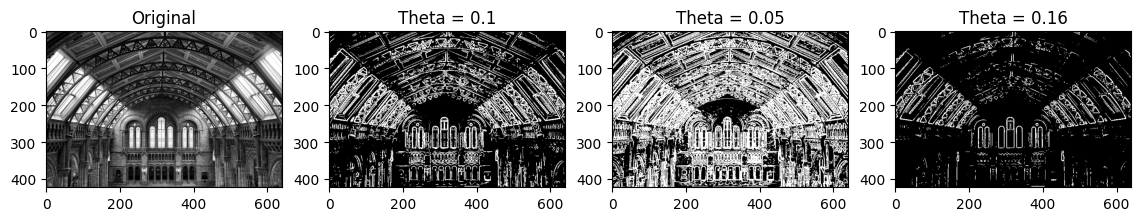

In [6]:
# (a) Firstly, create a function findedges that accepts an image I, 
# and the parameters sigma and theta. The function should create a binary matrix 
# Ie that only keeps pixels higher than threshold theta:
def findedges(I, sigma, theta):
    I_mag, angle = gradient_magnitude(I, sigma)
    binary_matrix = np.zeros(I_mag.shape)
    binary_matrix[I_mag >= theta] = 1
    return binary_matrix

museum_img = cv2.imread("images/museum.jpg", cv2.IMREAD_GRAYSCALE)
binary_matrix_1 = findedges(museum_img/255, 1, 0.1)
binary_matrix_2 = findedges(museum_img/255, 1, 0.05)
binary_matrix_3 = findedges(museum_img/255, 1, 0.16)

plt.figure(figsize=(14,6))
plt.subplot(1, 4, 1)
plt.imshow(museum_img, cmap='gray')
plt.title('Original')
plt.subplot(1, 4, 2)
plt.imshow(binary_matrix_1, cmap='gray')
plt.title('Theta = 0.1')
plt.subplot(1, 4, 3)
plt.imshow(binary_matrix_2, cmap='gray')
plt.title('Theta = 0.05')
plt.subplot(1, 4, 4)
plt.imshow(binary_matrix_3, cmap='gray')
plt.title('Theta = 0.16')
plt.show()

In [4]:
# (b) You will implement non-maxima suppression based on the image deriva- tive magnitudes and angles. 

def non_maxima_suppression(I, sigma, theta):
    I_mag,angle=gradient_magnitude(I,sigma)
    binary_matrix = findedges(I, sigma, theta)
    non_maxima_suppression = binary_matrix.copy()
    for i in range(1,I.shape[0]-1):
        for j in range(1,I.shape[1]-1):
            grad_angle = angle[i,j] * 180 / np.pi
            if grad_angle<0:
                grad_angle=grad_angle+360
            if grad_angle>360:
                grad_angle=grad_angle-360
            if grad_angle>337.5 or grad_angle<=22.5:
                neighbors = [I_mag[i, j+1], I_mag[i, j-1]]
            if grad_angle>22.5 and grad_angle<=67.5:
                neighbors = [I_mag[i + 1, j+1], I_mag[i-1, j-1]]
            if grad_angle>67.5 and grad_angle<=112.5:
                neighbors = [I_mag[i+1, j], I_mag[i-1, j]]
            if grad_angle>112.5 and grad_angle<=157.5:
                neighbors = [I_mag[i-1, j+1], I_mag[i+1, j-1]]
            if grad_angle>157.5 and grad_angle<=202.5:
                neighbors = [I_mag[i, j-1], I_mag[i, j+1]]  
            if grad_angle>202.5 and grad_angle<=247.5:
                neighbors = [I_mag[i-1, j-1], I_mag[i+1, j+1]]
            if grad_angle>247.5 and grad_angle<=292.5:
                neighbors = [I_mag[i-1, j], I_mag[i+1, j]]
            if grad_angle>292.5 and grad_angle<=337.5:
                neighbors = [I_mag[i+1, j-1], I_mag[i-1, j+1]] 

            if I_mag[i, j] < max(neighbors):
                non_maxima_suppression[i, j] = 0
    return non_maxima_suppression


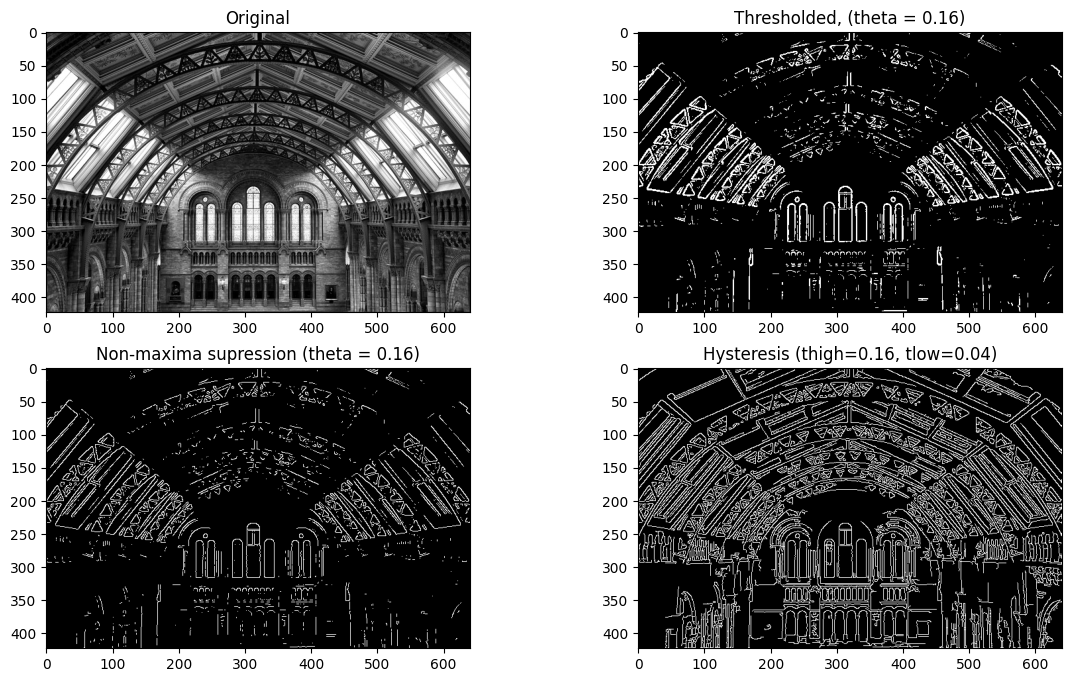

In [8]:
# (c) The final step of Canny’s algorithm is edge tracking by hysteresis. 
# Add the final step after performing non-maxima suppression along edges.

def hysteresis(I, sigma, theta, tlow, thigh):
    I_mag,angle=gradient_magnitude(I,sigma)

    supressed = I_mag.copy()
    for i in range(1,I.shape[0]-1):
        for j in range(1,I.shape[1]-1):
            grad_angle = angle[i,j] * 180 / np.pi
            if grad_angle<0:
                grad_angle=grad_angle+360
            if grad_angle>360:
                grad_angle=grad_angle-360
            if grad_angle>337.5 or grad_angle<=22.5:
                neighbors = [I_mag[i, j+1], I_mag[i, j-1]]
            if grad_angle>22.5 and grad_angle<=67.5:
                neighbors = [I_mag[i + 1, j+1], I_mag[i-1, j-1]]
            if grad_angle>67.5 and grad_angle<=112.5:
                neighbors = [I_mag[i+1, j], I_mag[i-1, j]]
            if grad_angle>112.5 and grad_angle<=157.5:
                neighbors = [I_mag[i-1, j+1], I_mag[i+1, j-1]]
            if grad_angle>157.5 and grad_angle<=202.5:
                neighbors = [I_mag[i, j-1], I_mag[i, j+1]]  
            if grad_angle>202.5 and grad_angle<=247.5:
                neighbors = [I_mag[i-1, j-1], I_mag[i+1, j+1]]
            if grad_angle>247.5 and grad_angle<=292.5:
                neighbors = [I_mag[i-1, j], I_mag[i+1, j]]
            if grad_angle>292.5 and grad_angle<=337.5:
                neighbors = [I_mag[i+1, j-1], I_mag[i-1, j+1]] 

            if I_mag[i, j] < max(neighbors):
                supressed[i, j] = 0

    hysteresis = supressed.copy()
    hysteresis[supressed>thigh]=1
    hysteresis[supressed<tlow]=0

    hysteresis_int=hysteresis*255
    hysteresis_int=hysteresis_int.astype(np.uint8)
    
    num_labels,labels,stats,centroids=cv2.connectedComponentsWithStats(hysteresis_int)
    
    for i in range(1,num_labels):
        pixels=np.where(labels==i)
        if np.any(supressed[pixels]>thigh):
            hysteresis[pixels]=1
        else:
            hysteresis[pixels]=0
    return hysteresis

   
supressed = non_maxima_suppression(museum_img/255, 1, 0.16)
hysteresis_img = hysteresis(museum_img/255, 1, 0.16, 0.04, 0.16)
plt.figure(figsize=(14,8))
plt.subplot(2, 2, 1)
plt.imshow(museum_img, cmap='gray')
plt.title('Original')
plt.subplot(2, 2, 2)
plt.imshow(binary_matrix_3, cmap='gray')
plt.title('Thresholded, (theta = 0.16)')
plt.subplot(2, 2, 3)
plt.imshow(supressed, cmap='gray')
plt.title('Non-maxima supression (theta = 0.16)')
plt.subplot(2, 2, 4)
plt.imshow(hysteresis_img, cmap='gray')
plt.title('Hysteresis (thigh=0.16, tlow=0.04)')
plt.show()